# Movie recommender with multinomial RBM (Python, Tensorflow, GPU)

A Restricted Boltzmann Machine (RBM) is used to perform collaborative filtering over the Movielens dataset.
The RBM is a generative model, it learns the joint probability distribution $P(v,h)$, where $v$ are the visible units and $h$ the hidden ones. The hidden units are latent variables while the visible units are clamped on the input data. The model generates ratings for a user/movie pair using a collaborative filtering based approach. 

The dataset contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users. The movies are ranked from 1-5; In the first iteration of this notebook we consider a simplifie version of the problem, implementing a binary encoding of the dataset. The reason for this choice is that one can use a more traditional binary RBM instead of a multinomial one, see below for further discussion.



## 0 Global Settings and Import

In [1]:
#load libraries

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys
sys.path.append("../../")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import papermill as pm
from zipfile import ZipFile

from reco_utils.recommender.rbm.Mrbm_tensorflow import RBM
from reco_utils.dataset.rbm_splitters import splitter

from reco_utils.dataset.url_utils import maybe_download
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

System version: 3.6.0 | packaged by conda-forge | (default, Feb  9 2017, 14:36:55) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas version: 0.23.4


# 1 Load Data 

In [2]:
# Select Movielens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '1m'

In [3]:
# MovieLens data have different data-format for each size of dataset 
data_header = None
if MOVIELENS_DATA_SIZE == '100k':
    separator = '\t'
    data_name = 'u.data'
    data_folder = 'ml-100k'
elif MOVIELENS_DATA_SIZE == '1m':
    separator = '::'
    data_name = 'ratings.dat'
    data_folder = 'ml-1m'
elif MOVIELENS_DATA_SIZE == '10m':
    separator = '::'
    data_name = 'ratings.dat'
    data_folder = 'ml-10M100K'
elif MOVIELENS_DATA_SIZE == '20m':
    separator = ','
    data_name = 'ratings.csv'
    data_folder = 'ml-20m'
    data_header = 0
else:
    raise ValueError('Invalid data size. Should be one of {100k, 1m, 10m, or 20m}') 

# Download dataset zip file and decompress if haven't done yet
data_path = os.path.join(data_folder, data_name)
if not os.path.exists(data_path):
    filename = 'ml-' + MOVIELENS_DATA_SIZE + '.zip'
    filepath = maybe_download('http://files.grouplens.org/datasets/movielens/'+filename, filename)

    with ZipFile(filepath, 'r') as zf:
        zf.extractall()
    
    # remove zip file we already used
    os.remove(filepath)
    
data = pd.read_csv(
    data_path,
    sep=separator,
    engine='python',
    names=['userID','MovieId','Rating','Timestamp'],
    header=data_header
)
data.head()

,userID,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 1.2 Split the data using the stratified splitter  

In [9]:
header = {
        "col_user": "userID",
        "col_item": "MovieId",
        "col_rating": "Rating",
    }

split = splitter(DF = data, **header)

Xtr, Xtst, train_df, test_df, maps = split.stratified_split()

Generating the user/item affinity matrix...


Matrix generated, sparsness: 95 % size: (6040, 3706)


Note that the train/test matrices have exactly the same same dimension, but different entries


In [10]:
print('train matrix size', Xtr.shape)
train_df.head()

train matrix size (6040, 3706)


,userID,MovieId,Rating
0,1,1193,5
1,1,745,3
2,1,3186,4
3,1,1566,4
4,1,588,4


In [11]:
print('test matrix size', Xtst.shape)
test_df.head()

test matrix size (6040, 3706)


,userID,MovieId,Rating
0,1,2294,4
1,1,2762,4
2,1,260,4
3,1,1028,5
4,1,1961,5


For details on how the splitter operates see ...

## 2 Train the RBM model






As a first step we need to initialize the model class. 

In [17]:
#First we initialize the model class
model = RBM(hidden_units= 1000,save_model = True, training_epoch = 100, minibatch_size= 1000,**header)

Then we apply the `fit()` method to the data in order to train the model. The `fit()` method takes two arguments: the training set matrix Xtr and the test set matrix Xtst. The former is used to train and evaluate the model while the latter is only used to evaluate the total mean average precision. These two quantities can be used to understand in which direction the model hyperparameters needs to be tuned.  
Note that the first time the fit method is called, it may take a few seconds to initialize the tensor-flow GPU session. 

Creating the computational graph


training epoch 0 rmse Train 1.094911 
training epoch 10 rmse Train 0.970836 
training epoch 20 rmse Train 0.947062 
training epoch 30 rmse Train 0.933710 
training epoch 40 rmse Train 0.926223 
training epoch 50 rmse Train 0.917515 
training epoch 60 rmse Train 0.908160 
training epoch 70 rmse Train 0.902421 
training epoch 80 rmse Train 0.893773 
training epoch 90 rmse Train 0.890050 
training epoch 100 rmse Train 0.883242 
train set MAP 0.39224708
test set MAP 0.37965146
train/test difference 0.012595624


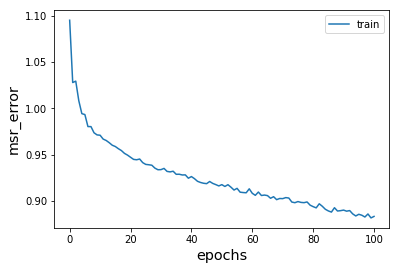

In [18]:
model.fit(Xtr, Xtst)

In [19]:
TOP_K = 10

top_k =  model.recommend_k_items(Xtst, maps)

# TODO: remove this call when the model returns same type as input
top_k['userID'] = pd.to_numeric(top_k['userID'])
top_k['MovieId'] = pd.to_numeric(top_k['MovieId'])

display(top_k.head(10) ) 

Restoring parameters from saver/rbm_model_saver.ckpt
Formatting output


,userID,MovieId,prediction
0,1,527,4.996905
1,1,1028,4.994778
2,1,2847,4.994009
3,1,1961,4.993125
4,1,1925,4.984685
5,1,2633,4.984084
6,1,1412,4.982432
7,1,171,4.979842
8,1,2933,4.978740
9,1,1076,4.978277


## 4 Evaluation metrics 

Here we evaluate the performance of the algorithm using the metrics provided in the `PythonRankingEvaluation` class

In [20]:
eval_map = map_at_k(test_df, top_k, col_user="userID", col_item="MovieId", 
                    col_rating="Rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= TOP_K)

In [21]:
eval_ndcg = ndcg_at_k(test_df, top_k, col_user="userID", col_item="MovieId", 
                      col_rating="Rating", col_prediction="prediction", 
                      relevancy_method="top_k", k=TOP_K)

In [22]:
eval_precision = precision_at_k(test_df, top_k, col_user="userID", col_item="MovieId", 
                                col_rating="Rating", col_prediction="prediction", 
                                relevancy_method="top_k", k= TOP_K)

In [23]:
eval_recall = recall_at_k(test_df, top_k, col_user="userID", col_item="MovieId", 
                          col_rating="Rating", col_prediction="prediction", 
                          relevancy_method="top_k", k=TOP_K)

In [24]:
print(
      "Top K:\t%d" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

Top K:	10
MAP:	0.103331
NDCG:	0.378335
Precision@K:	0.312881
Recall@K:	0.156172
